# Проект 10 - Эксперименты с шрифтами мобильного приложения

## Введение

**Описание проекта**

Мы работаетем в стартапе, который продаёт продукты питания. Нужно разобраться, как ведут себя пользователи вашего мобильного приложения. Посмотрим воронку продаж: сколько пользователей доходит до покупки, а сколько — «застревает» на предыдущих шагах? На каких именно?

После этого исследуем результаты A/A/B-эксперимента. Дизайнеры захотели поменять шрифты во всём приложении, а менеджеры испугались, что пользователям будет непривычно. Договорились принять решение по результатам A/A/B-теста. Пользователей разбили на 3 группы: 2 контрольные `246` и `247` со старыми шрифтами и одну экспериментальную `248` — с новыми. Выясним, какой шрифт лучше.

**Описание данных**

Таблица `logs_exp.csv`:

1. `EventName` — название события
2. `DeviceIDHash` — уникальный идентификатор пользователя
3. `EventTimestamp` — время события
4. `ExpId` — номер эксперимента

In [4]:
import pandas as pd
import numpy as np
import math as mth
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from scipy import stats as st
from datetime import date, timedelta
from IPython.display import display
plt.style.use('default')

# Save raw datasets in case we need them
try:
    raw_logs = pd.read_csv('logs_exp.csv', sep='\t')
except:
    raw_logs = pd.read_csv('/datasets/logs_exp.csv', sep='\t')

# Constants, which we will need later
FIG_WIDTH = 10
FIG_HEIGHT = 5


## Предобработка данных

Для начала проверим какие данные нам достались. Нас интересуют:

1. Названия колонок.
2. Артефакты в данных.
3. Типы данных.

Пойдем по порядку.

In [5]:
# Let's have a look inside
raw_logs.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


У нас не PEP-8 угодные названия колонок, странный формат и тип данных колонки с `timestamp` (unix-time?), а также нам надо добавить отдельный столбец с датой. Поправим это.

Есть вероятность, что у нас будут дупликаты в данных. Я думаю, что логично будет их убрать: вряд ли у нас будет уникальный пользователь (судя по `device_id_hash`), который в одно и то же время (до секунд) сделает одно и то же действие, c одного и того же устройства.

Наконец, у нас, похоже, нет пропущенных значений в данных, что и хорошо.

In [6]:
# Time to clean things up a bit
df_logs = (
    raw_logs
    .copy()
    .rename(
        columns={
            'EventName': 'name_event',
            'DeviceIDHash': 'id_device',
            'EventTimestamp': 'dt_event',
            'ExpId': 'id_group'
        }
    )
    .astype({
        'name_event': 'object',
        'id_device': 'int64',
        'dt_event': 'datetime64[s]',
        'id_group': 'object'
    })
    .assign(
        name_event = lambda df: df.name_event.str.replace('(?<!^)([A-Z])', r' \1', regex=True),
        date_event = lambda df: pd.to_datetime(df.dt_event, unit='s').dt.date,
        id_group = lambda df: df.id_group.replace([246, 247, 248], ['A1', 'A2', 'B'])
    )
    .drop_duplicates()
)

print('Total number of rows in a raw dataset:', raw_logs.EventName.count())
print('Total number of rows in a cleaned dataset:', df_logs.name_event.count())
print('Number of deleted duplicates:',
      round(100 - 100 * df_logs.name_event.count() / raw_logs.EventName.count(), 2), '%' )


Total number of rows in a raw dataset: 244126
Total number of rows in a cleaned dataset: 243713
Number of deleted duplicates: 0.17 %


0.17% удаленных записей не звучит криминально. Можем переходить к описательному анализу данных.

## Исследовательский анализ данных

Посчитаем некоторую высокоуровневую статистику по нашему датасету. Посмотрим, сколько у нас событий, уникальных пользователей, как они распределены по группам, и прочее.

In [7]:
# Dataset statisitcs
print('Total number of events:',
      df_logs.name_event.count())
print('Total number of unique users:',
      df_logs.id_device.nunique())
print('Average # of events per unique user:', 
      round(df_logs.name_event.count() / df_logs.id_device.nunique(), 1))


Total number of events: 243713
Total number of unique users: 7551
Average # of events per unique user: 32.3


Статистика интересная, но прежде, чем делать выводы, надо узнать за какой она период.

Minimum date is 2019-07-25
Maximum date is 2019-08-07


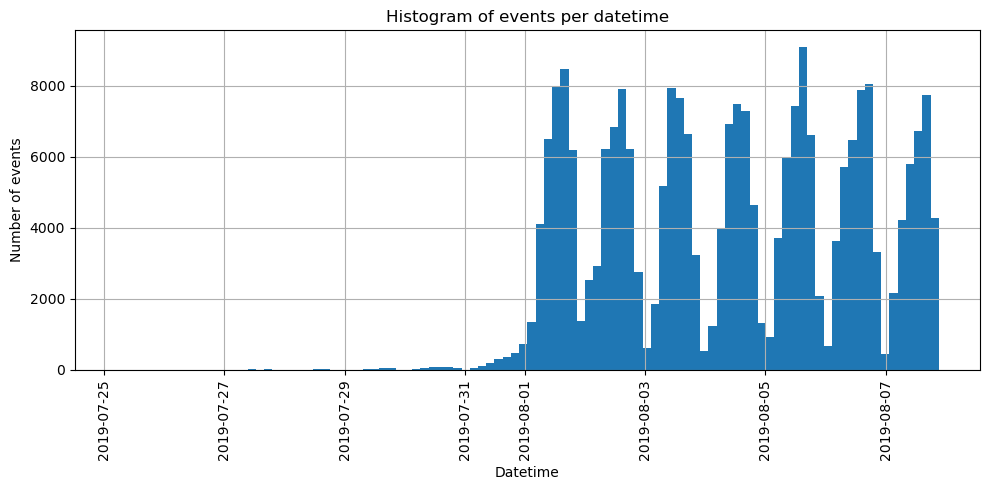

In [8]:
# Minimum and maximum dates in the dataset
print('Minimum date is', min(df_logs.date_event))
print('Maximum date is', max(df_logs.date_event))
df_logs.dt_event.hist(bins=100, figsize=[FIG_WIDTH, FIG_HEIGHT], xrot=90);
plt.title('Histogram of events per datetime')
plt.xlabel('Datetime')
plt.ylabel('Number of events')
plt.tight_layout()


Похоже, наши данные покрывают не только период "нормальной" работы приложения, но и, например, период разработки - когда приложение могло быть недоступно широкой публике. Для нашего анализа нам придется обрезать датасет, чтобы избежать ошибочных выводов. Возьмем данные с `2019-08-01` - сразу после относительно значительного роста количества пользователей.

Другое интересное наблюдение - это явная сезонность в использовании нашего приложения. Наши данные покрывают период нескольких дней: видимо, пользователи делают заказы днем, а ночью не делают.

In [9]:
# Summary function to compare filtering results
def fun_get_statistics_comparison(
        df_before: pd.DataFrame,
        df_after: pd.DataFrame,
        index: str,
        values: str,
        aggfunc: str
    ) -> pd.DataFrame:
    """
    This function compares summaries of 2 dataframes and returns a total summary with % difference across specified dimensions

    Args:
        df_before (pd.DataFrame): initial dataframe 
        
        df_after (pd.DataFrame): dataframe after some kind of transformation
        
        index (str): column name that will be taken as index used in an pd.pivot_table().
        This has to be the same for both datasets
        
        values (str): column name that will be taken as values used in in an pd.pivot_table().
        This has to be the same for both datasets
        
        aggfunc (str): column name that will be taken as aggregate function used in in an pd.pivot_table().
        This has to be a single function

    Returns:
        pd.DataFrame: a summary dataframe, where rows are unique values from index column and 3 columns:
        results of aggfunc applied to df_before, df_after and a comparison % = df_after / df_before
    """
    
    name_column_before = values + '_' + aggfunc + '_' + 'before'
    name_column_after = values + '_' + aggfunc + '_' + 'after'
    
    df_summary = (
        pd.merge(
            left=(
                pd.pivot_table(
                    data=df_before,
                    index=index,
                    values=values,
                    aggfunc=aggfunc,
                    margins=True
                )
                .reset_index()
                .set_axis(
                    [index, name_column_before],
                    axis='columns'
                )
            ),
            right=(
                pd.pivot_table(
                    data=df_after,
                    index=index,
                    values=values,
                    aggfunc=aggfunc,
                    margins=True
                )
                .reset_index()
                .set_axis(
                    [index, name_column_after],
                    axis='columns'
                )
            ),
            on=index,
            how='left'
        )
        .assign(
            change_per = lambda df: 100 * round(df[name_column_after] / df[name_column_before], 3) 
        )
    )
    
    return df_summary


Проверим, что будет с нашими данными, если мы обрежем верменной промежуток для анализа. Нас интересует количество событий и количество уникальных пользователей.

In [10]:
fun_get_statistics_comparison(
    df_logs, 
    df_logs[df_logs.date_event >= date(2019, 8, 1)],
    'id_group', 'id_device', 'nunique'
)

,id_group,id_device_nunique_before,id_device_nunique_after,change_per
0,A1,2489,2484,99.8
1,A2,2520,2513,99.7
2,B,2542,2537,99.8
3,All,7551,7534,99.8


In [11]:
fun_get_statistics_comparison(
    df_logs, 
    df_logs[df_logs.date_event >= date(2019, 8, 1)],
    'id_group', 'id_device', 'count'
)

,id_group,id_device_count_before,id_device_count_after,change_per
0,A1,80181,79302,98.9
1,A2,77950,77022,98.8
2,B,85582,84563,98.8
3,All,243713,240887,98.8


Потерянные данные минимальны - в первом случае мы потеряли всего 0.2% уникальных пользователей из ~7K, а во втором - чуть больше 1% всех событий. У нас также нет перекосов по группам для А/А/B теста. Перезапишем наш датасет и перейдем к следующим приключениям.

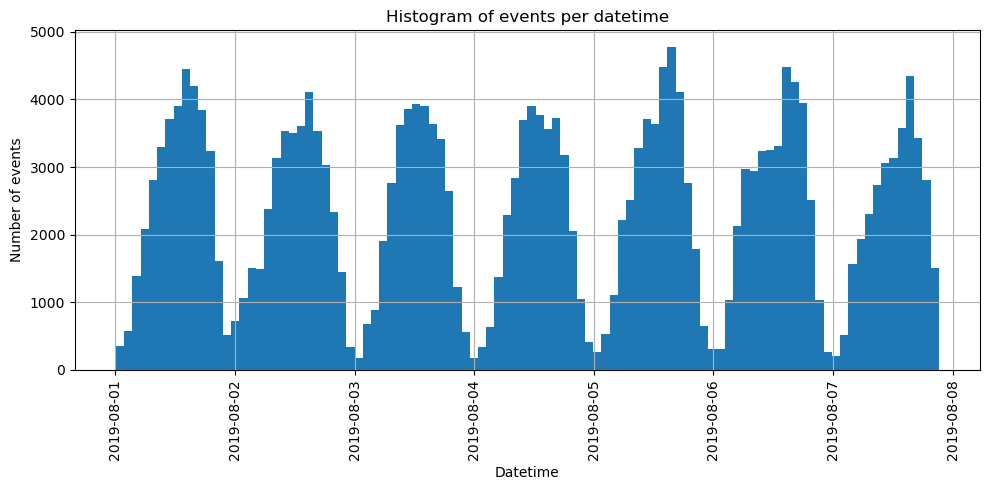

In [12]:
df_logs = df_logs[df_logs.date_event >= date(2019, 8, 1)]
df_logs.dt_event.hist(bins=100, figsize=[FIG_WIDTH, FIG_HEIGHT], xrot=90);
plt.title('Histogram of events per datetime')
plt.xlabel('Datetime')
plt.ylabel('Number of events')
plt.tight_layout()


## Анализ воронки событий

Посмотрим теперь на события в логах, как часто они встречаются, как ведут себя пользователи.

In [13]:
# Events pipeline
(pd.pivot_table(
    data=df_logs,
    index='name_event',
    values='id_device',
    aggfunc='count',
    # margins=True
 )
 .reset_index()
 .set_axis(
    ['name_event', 'event_count'],
    axis='columns'
 )
 .sort_values(by='event_count', ascending=False)
)

,name_event,event_count
1,Main Screen Appear,117328
2,Offers Screen Appear,46333
0,Cart Screen Appear,42303
3,Payment Screen Successful,33918
4,Tutorial,1005


В нашей воронке событий 5 шагов. События расположены не совсем в логическом порядке: `tutorial` проходят, вероятно, до использования сервиса, чтобы понять, как оставить заказ. Остальные шаги выглядят разумно: начинаем с основного экрана, где-то во время кликов получаем экран с предолжениями, переходим в корзину и платим за заказ.

Посмотрим, сколько уникальных пользователей прошли по нашей воронке.

In [14]:
# Users in the pipeline
df_temp = (
    pd.pivot_table(
        data=df_logs[df_logs.name_event != 'Tutorial'],
        index='name_event',
        values='id_device',
        aggfunc='nunique',
        # margins=True
    )
    .reset_index()
    .set_axis(
        ['name_event', 'user_unique_count'],
        axis='columns'
    )
    .sort_values(by='user_unique_count', ascending=False)
    .assign(
        conversion_step_per = lambda df: round(
            100 * df.user_unique_count /  df.user_unique_count.shift(1), 1
        ),
        conversion_total_per = lambda df: round(
            100 * df.user_unique_count /  df.user_unique_count.max(), 1
        ),
        conversion_total_all_users_per = lambda df: round(
            100 * df.user_unique_count /  df_logs.id_device.nunique(), 1
        ),
    )
    .fillna(100)
)

display(df_temp)

print(
    'Main screen to successful payment conversion',
    round(
        100 * df_logs[df_logs.name_event == 'Payment Screen Successful'].id_device.nunique()
        / df_logs[df_logs.name_event == 'Main Screen Appear'].id_device.nunique(), 2
    ), '%'
)


,name_event,user_unique_count,conversion_step_per,conversion_total_per,conversion_total_all_users_per
1,Main Screen Appear,7419,100.0,100.0,98.5
2,Offers Screen Appear,4593,61.9,61.9,61.0
0,Cart Screen Appear,3734,81.3,50.3,49.6
3,Payment Screen Successful,3539,94.8,47.7,47.0


Main screen to successful payment conversion 47.7 %


In [15]:
# Pipeline visualization
go.Figure(
    go.Funnel(
        y=df_temp.name_event,
        x=df_temp.user_unique_count,
        textinfo = "value+percent initial"
    )
).show()

С пользователями похожая ситуация. Можно заметить, что у нас отваливаются пользователи в переходе между главным экраном и экраном с предложениями - здесь конверсия с предыдущего шага самая маленькая. Общая конверсия с момента первого события до оплаты почти 50% - слжоно сказать хорошо это или плохо, т.к. мы не знаем деталей бизнеса, но выглядит адекватно.

Посмотрим, какое количество пользователей сделали по одному, два, и т.д. событий.

In [16]:
# Users in the pipeline
df_temp = (
    pd.pivot_table(
        data=df_logs[df_logs.name_event != 'Tutorial'],
        index='id_device',
        values='name_event',
        aggfunc='nunique',
        # margins=True
    )
    .reset_index()
    .set_axis(
        ['id_device', 'name_event_count'],
        axis='columns'
    )
    .sort_values(by='name_event_count', ascending=False)
)

(pd.pivot_table(
    data=df_temp,
    index='name_event_count',
    values='id_device',
    aggfunc='count',
    margins=True  
 )
 .reset_index()
 .set_axis(
     ['events_count', 'users_unique_count'],
     axis='columns'
 )
 .assign(
     users_vs_total_per = lambda df: round(
         100 * df.users_unique_count / df.users_unique_count.iloc[-1], 1
     )
 )
)

,events_count,users_unique_count,users_vs_total_per
0,1,2894,38.4
1,2,946,12.6
2,3,261,3.5
3,4,3429,45.5
4,All,7530,100.0


А вот это уже странно. У нас, вроде, правильное суммарное количество уникальных пользователей, но почему-то пользователей, прошедших через 3 события, меньше, чем пользователей прошедших через все события. Откуда эти пользователи взялись? Загадка.

**Вывод:** в итоге, в нашей воронке мы имеем всего 5 событий, но разумно будет рассматривать только 4 (обучение пропускаем). Из оставшихся шагов большего всего пользователей отваливаются после основного экрана. Возможно, они просто не нашли на нашем сайте то, что искали и ушли ногами закупаться в Азбуке Вкуса. Тем не менее, на следующих этапах у нас довольно большая конверсия (~80%). Суммарно, около половины пользователей (47%) доходят до покупки в нашем приложении.

## A/A/B тесты

### Проверка данных

Начнем готовится к нашим тестам. Посмотрим, есть ли у нас пользователи, которые оказались в нескольких группах одновременно.

In [17]:
# Number of users
(pd.pivot_table(
    data=df_logs,
    index='id_device',
    values='id_group',
    aggfunc='nunique'
 )
 .max()
)

id_group    1
dtype: int64

Максимальное количество уникальных групп, в которых состят наши пользователи равно `1`. Это значит, что перебезжчиков между группами нет. Посмотрим, сколько всего пользователей в каждой группе.

In [18]:
# Number of users
(pd.pivot_table(
    data=df_logs,
    index='id_group',
    values='id_device',
    aggfunc='nunique',
    margins=True
 )
 .reset_index()
 .set_axis(
     ['id_group', 'users_unique_count'],
     axis='columns'
 )
 .assign(
     users_unique_per = lambda df: round(
         100 * df.users_unique_count / df.users_unique_count.iloc[-1], 1
     )
 )
)

,id_group,users_unique_count,users_unique_per
0,A1,2484,33.0
1,A2,2513,33.4
2,B,2537,33.7
3,All,7534,100.0


Количество пользователей в группах не отличается более чем на 1%. Ну и хорошо.

Последним упражнением проверим, как группы были распеределены во времени. Просто из любопытства.

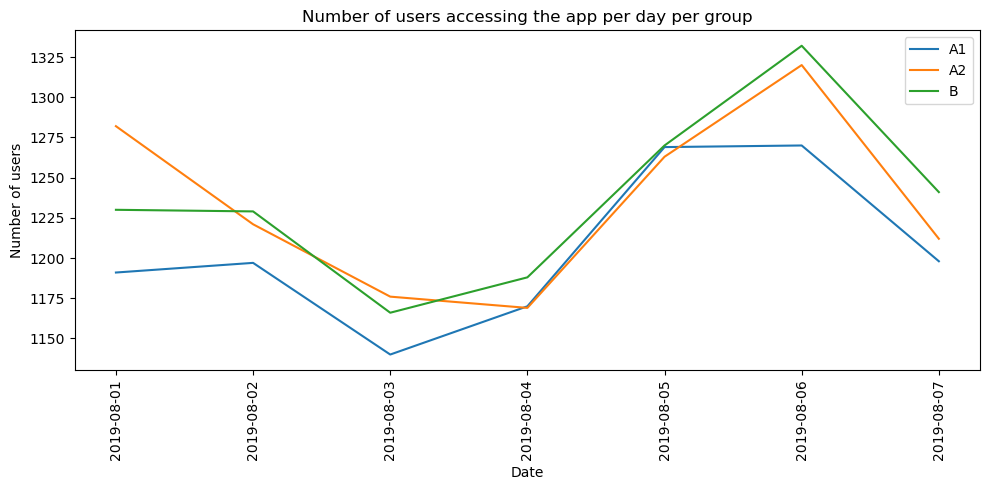

In [19]:
# Number of users
(pd.pivot_table(
    data=df_logs,
    index='date_event',
    columns='id_group',
    values='id_device',
    aggfunc='nunique'
 )
 .reset_index()
 .set_axis(
     ['date', 'A1', 'A2', 'B'],
     axis='columns'
 )
 .plot(
     x='date',
     kind='line',
     title='Number of users accessing the app per day per group',
     xlabel='Date',
     ylabel='Number of users',
     figsize=[FIG_WIDTH, FIG_HEIGHT],
     rot=90
 )
);
plt.tight_layout()

Интересно, что визуально группы А2 и В очень похожи, а группа А1 по количеству пользователей просядает. Посмотрим, что скажут статистические тесты.


### А/А тесты

Освновное упражнение в этой и следующих секциях - проверить статистическую значимость различия конверсий на каждом шаге между группами. С этим нам поможет Z-тест. Чтобы минимизировать вероятность ошибок, выберем уровень значимости `alpha = 0.01`. 

Первым делом, соберем данные в таблицу, которую будем использовать.

In [20]:
pvt_summary = (
    pd.pivot_table(
        data=df_logs[df_logs.name_event != 'Tutorial'],
        index='name_event',
        columns='id_group',
        values='id_device',
        aggfunc='nunique',
        margins=True,
        margins_name='All users'
    )
    .reset_index()
    .drop('All users', axis=1)
    .set_axis(
        ['name_event', 'A1', 'A2', 'B'],
        axis='columns'
    )
    .assign(
        A12 = lambda df: df.A1 + df.A2
    )
    .sort_values(by='B', ascending=False)
)
 
display(pvt_summary)

,name_event,A1,A2,B,A12
4,All users,2483,2512,2535,4995
1,Main Screen Appear,2450,2476,2493,4926
2,Offers Screen Appear,1542,1520,1531,3062
0,Cart Screen Appear,1266,1238,1230,2504
3,Payment Screen Successful,1200,1158,1181,2358


Напишем функцию, которая будет делать за нас Z-тест. 

In [21]:
# Hypothesis testing
def fun_get_p_value(start_count: list, end_count: list, alpha: float) -> float:
    """
    This function output p-value of a Z-test for conversions of 2 samples.

    Args:
        start_count (list): list of starting values.
        end_count (list): list of values after an event.
        alpha (float): statistical significance

    Returns:
        p-value: p-value of a test
    """
    
    p1 = end_count[0] / start_count[0]
    p2 = end_count[1] / start_count[1]
    
    p_combined = (end_count[0] + end_count[1]) / (start_count[0] + start_count[1])
    difference = p1 - p2
    
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1 / start_count[0] + 1 / start_count[1]))
    
    distribution = st.norm(0, 1)
    p_value = (1 - distribution.cdf(abs(z_value))) * 2

    return p_value

Теперь проверим есть ли статистически значимая разница между группами А1 и А2. Т.к. мы еще не раз вернемся к гипотезам ниже, я напишу их в общем виде, подразумевая, что вместо групп 1 и 2 мы будем выбирать нужные нам комбинации.

> **Нулевая гипотеза (H0):** статистически значимых различий между конверсиями группы 1 и конверсиями группы 2 нет.

> **Альтернативная гипотеза (H1):** статистически значимые различия между конверсиями группы 1 и конверсиями группы 2 есть.

Мы принимаем нулевую гипотезу, если `p_value > alpha`. Мы принимаем альтернативную гипотезу, если `p_value < alpha`. Напишем еще одну функцию, которая будет шерстить по нашей таблице `pvt_summary`.

In [22]:
# Results for several hypotheses
def fun_hypothesis_results(df_input: pd.DataFrame, group_1: object, group_2: object, alpha: float) -> pd.DataFrame:
    """
    This function creates a summary report after testing hypotheses related to conversion.

    Args:
        df_input (DataFrame): input dataframe
        group_1 (object): name of the column which contains total unique users per each step of the pipeline for the first group 
        group_2 (object): name of the column which contains total unique users per each step of the pipeline for the second group
        alpha (float): statistical significance.

    Returns:
        DataFrame: summary table of key results for each test: steps in scope, conversions, p_value, alpha and H0/H1 decision.
    """
    
    start_event = []
    end_event = []
    conversion_group_1 = []
    conversion_group_2 = []
    p_values = []
    hypothesis_to_accept = []
    
    for counter in range(len(df_input.name_event) - 1):       
        start_event.append(df_input.name_event.iloc[0])
        end_event.append(df_input.name_event.iloc[counter + 1])
        
        conversion_group_1.append(
            round(100 * df_input[group_1].iloc[counter + 1] / df_input[group_1].iloc[0], 1)
        )
        
        conversion_group_2.append(
            round(100 * df_input[group_2].iloc[counter + 1] / df_input[group_2].iloc[0], 1)
        )
        
        p_value = fun_get_p_value(
            [df_input[group_1].iloc[0], df_input[group_2].iloc[0]],
            [df_input[group_1].iloc[counter + 1], df_input[group_2].iloc[counter + 1]],
            alpha
        )
        
        p_values.append(round(p_value, 3))
        
        if p_value > alpha:
            hypothesis_to_accept.append('H0')
        else:
            hypothesis_to_accept.append('H1')

    df_output = pd.DataFrame({
        'start_event': start_event,
        'end_event': end_event,
        'conversion_group_' + group_1: conversion_group_1,
        'conversion_group_' + group_2: conversion_group_2,
        'p_value': p_values,
        'alpha': alpha,
        'hypothesis_to_accept': hypothesis_to_accept
    })
    
    return df_output


Настало время узнать ответ: есть ли разница между группами `A1` и `А2`.

In [23]:
alpha = 0.01

display(fun_hypothesis_results(pvt_summary, 'A1', 'A2', alpha))

,start_event,end_event,conversion_group_A1,conversion_group_A2,p_value,alpha,hypothesis_to_accept
0,All users,Main Screen Appear,98.7,98.6,0.753,0.01,H0
1,All users,Offers Screen Appear,62.1,60.5,0.248,0.01,H0
2,All users,Cart Screen Appear,51.0,49.3,0.229,0.01,H0
3,All users,Payment Screen Successful,48.3,46.1,0.114,0.01,H0


Статистической разницы в конверсиях на каждом шаге воронки нет. Похоже, мы можем использовать обе группы, как контрольные.

### Тесты А1/В, А2/В, А1+А2/В

Посмотрим теперь, есть ли какие-то различия между контрольными группами и экспериментальной. Параметры теста оставляем пока такими же.

In [24]:
display(fun_hypothesis_results(pvt_summary, 'A1', 'B', alpha))

,start_event,end_event,conversion_group_A1,conversion_group_B,p_value,alpha,hypothesis_to_accept
0,All users,Main Screen Appear,98.7,98.3,0.339,0.01,H0
1,All users,Offers Screen Appear,62.1,60.4,0.214,0.01,H0
2,All users,Cart Screen Appear,51.0,48.5,0.081,0.01,H0
3,All users,Payment Screen Successful,48.3,46.6,0.217,0.01,H0


Первый подход к снаряду показывает, что разницы между группами `A1` и `B` нет. `p_value` для всех шагов воронки много больше значения `alpha` - принимаем нулевую гипотезу.

In [25]:
display(fun_hypothesis_results(pvt_summary, 'A2', 'B', alpha))

,start_event,end_event,conversion_group_A2,conversion_group_B,p_value,alpha,hypothesis_to_accept
0,All users,Main Screen Appear,98.6,98.3,0.519,0.01,H0
1,All users,Offers Screen Appear,60.5,60.4,0.933,0.01,H0
2,All users,Cart Screen Appear,49.3,48.5,0.588,0.01,H0
3,All users,Payment Screen Successful,46.1,46.6,0.728,0.01,H0


Второй подход к снаряду показывает, что разницы между группами `A2` и `B` нет. `p_value` снова для всех шагов воронки много больше значения `alpha` - принимаем нулевую гипотезу.

In [26]:
display(fun_hypothesis_results(pvt_summary, 'A12', 'B',  alpha))

,start_event,end_event,conversion_group_A12,conversion_group_B,p_value,alpha,hypothesis_to_accept
0,All users,Main Screen Appear,98.6,98.3,0.349,0.01,H0
1,All users,Offers Screen Appear,61.3,60.4,0.446,0.01,H0
2,All users,Cart Screen Appear,50.1,48.5,0.187,0.01,H0
3,All users,Payment Screen Successful,47.2,46.6,0.611,0.01,H0


Последний подход к снаряду показывает, что разницы между группами `A12` и `B` нет. `p_value` для всех шагов воронки много больше значения `alpha` - принимаем нулевую гипотезу.

### Заключение и выводы

Последнее, о чем следует поговорить - это возможные ошибки. Мы сделали всего 12 тестов, что увеличивает вероятность отклонить нулевую гипотезу, при условии, что она верна. Похоже, это у нас и случилось в одной из итераций.

Чтобы этого избежать, можно принять попровачный коэффициент (например, Бонферрони). При "стандартной" альфе в `0.05` это даст нам значение `alpha = 0.05 / 16 = 0.003125`. Это все еще сильно меньше, чем `p-values`, которые мы получили.

Выводы:

1. У нас получился насыщенный проект: мы начали с загрузки и отчистки данных, потом собрали основную статистику по пользователям и событиям, затем перешли к проверке гипотез. Пара основных наблюдений:
- Временной период в исследовании: `2019-07-25` по `2019-08-07`. Но в нашей работе мы начали с `2019-08-01`, т.к. до этой даты данных почти нет.
- Общее количество пользователей чуть больше `7.5K`. Общее количество событий - больше `200K`.
- У нас 4 шага воронки, которые мы рассматривали. Суммарная конверсия от основного экрана до покупки составила `47.7%`. Больше всего пользователей отваливаются на этапе перехода с главного экрана на экран предложения.


2. Гипотезы проверяли по 3 контрольным группам (`A1`, `A2`, `A1 + A2`) и одной экспериментальной (`B`). К сожалению, исследование показало, что изменение шрифтов не повлияло на конверсию в нашем приложении. Но кто работал - молодец.


3. В дальнейшем, имеет смысл посмотреть на последние шаги воронки - здесь у нас самые горячие пользователи, а все равно 5% из них не оплачивают заказ - почему? Может, здесь есть быстрое решение, которое позволит немедленно получить денег.
   